In [1]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# TF extensions
from tensorboard.plugins.hparams import api as hp
# Python
import os
import json
from functools import partial
from google.cloud import storage
# Custom
from utils import preview

In [2]:
# Cloud storage
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../credentials/sticky-notes1-data-access.json'

# Add before any TF calls - initializes the keras global outside of any tf.functions
temp = tf.zeros([4, 32, 32, 3])
preprocess_input(temp);

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def load_metadata(tfrecord_path):
    """
    Load METADATA.json file from the tfrecord parent directory
    """
    data_dir = os.path.dirname(tfrecord_path)
    if data_dir.startswith('gs://'):
        # Extract bucket and blob name from path
        bucket_name = data_dir[5:].split('/')[0]
        data_dir = data_dir.replace(f'gs://{bucket_name}/', '')
        # Load metadata
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.get_blob(os.path.join(data_dir, 'METADATA.json'))
        metadata = blob.download_as_string()
        metadata = json.loads(metadata)
    else:
        metadata = json.load(open(os.path.join(data_dir, 'METADATA.json')))
    return metadata

def parse_image(tfrecord, tfrecord_feature_description, image_shape):
    """
    Parse image, label and bounding box from a tfrecord example
    """
    # Parse single example
    tf_example = tf.io.parse_single_example(tfrecord, tfrecord_feature_description)
    # Decode and preprocess image
    image = tf.io.decode_raw(tf_example['image_raw'], tf.uint8)
    image = tf.reshape(image, image_shape)
    image = preprocess_input(image)
    # Decode label
    label = tf_example['label']
    label = (label == 'stickie')
    #bbox = tf_example['bbox']
    return image, label

def read_dataset(tfrecord_path, batch_size=32, repeat=None):
    """
    Read tfrecord dataset of images, labels and bounding boxes from storage
    """
    # Arguments for data parsing
    metadata = load_metadata(tfrecord_path)
    image_shape = (
        metadata['dimensions']['height'],
        metadata['dimensions']['width'],
        metadata['dimensions']['channels']
    )
    tfrecord_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.FixedLenFeature([], tf.string)
    }
    
    # Load and parse data
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(
        lambda x: parse_image(x, tfrecord_feature_description, image_shape),
        num_parallel_calls=AUTOTUNE
    )
    # Repeat, shuffle, batch and prefetch
    dataset = dataset.repeat(repeat).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
    
    # Determine how many steps to run per epoch from the metadata
    split = tfrecord_path.split('/')[-1].split('.')[0]  # returns train/val/test
    num_examples = metadata['num_examples'][split]
    num_steps = num_examples // batch_size

    return dataset, num_steps

In [4]:
# Custom Hparams callbacks
class HparamsMetricCallback(tf.keras.callbacks.Callback):
    """
    Metric callback for Hparams dashboard
    Eager execution mode only (there might be a way to use @tf.function)
    """
    def __init__(self, metric, log_dir):
        """
        Arguments:
        - metric - str - validation metric (should correspond to a metric used in `model.compile`)
        - log_dir - str - log directory to store the metric (should be same dir as Tensorboard)
        
        Example:
        ```
        model.compile(..., metrics=['accuracy'])
        tensorboard_cb = Tensorboard(log_dir=log_dir)
        hparams_metric_cb = HparamsMetricCallback(metric='val_accuracy', log_dir=log_dir)
        ```
        """
        self.metric = metric
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs):
        """
        This function will automatically be called during a model.fit() call
        Creates a tf.summary from the validation metric stored in the training logs
        """
        with tf.summary.create_file_writer(self.log_dir).as_default():
            tf.summary.scalar(self.metric, logs[self.metric], epoch)

            
def create_hparams_callbacks(log_dir, opt_metric, hparams, args):
    """
    Create the two callbacks necessary to use hparams in Tensorboard
    """
    # Hparams metric callback to log the validation score
    hparams_metric_cb = HparamsMetricCallback(
        metric=opt_metric,
        log_dir=log_dir
    )
    # Hparams callback to log the hyperparameter values
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams_config(
            hparams=[hp.HParam(hparam)for hparam in hparams],
            metrics=[hp.Metric(opt_metric)]
        )
    hparams_cb = hp.KerasCallback(
        writer=log_dir,
        hparams={hparam: args[hparam] for hparam in hparams}
    )
    return hparams_metric_cb, hparams_cb

In [5]:
def create_model(args, metrics, **kwargs):
    """
    Create trainable model initialised from VGG-16 pretrained on ImageNet
    """
    # Pre-trained model
    if args['initial_weights_path'] is None:
        vgg = VGG16(weights='imagenet', input_tensor=Input(shape=(224, 224, 3)), include_top=False)
    else:
        vgg = VGG16(weights=None, input_tensor=Input(shape=(224, 224, 3)), include_top=False)
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False

    # Add trainable output layer
    flatten_layer = Flatten()
    output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(l=args['l2_regularisation']))
    output = vgg.layers[-1].output
    output = output_layer(flatten_layer(output))
    model = Model(vgg.input, output)

    # Load weights (from gcloud or local storage)
    weights_path = args['initial_weights_path']
    if weights_path is not None:
        print('Initialising model with weights from:', weights_path)
        model.load_weights(weights_path)
    
    # Compile
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=args['learning_rate']),
        metrics=metrics
    )

    return model

In [6]:
# View the network architecture and number of parameters
#create_model({'learning_rate': 0.1, 'l2_regularisation': 0.1}, ['accuracy']).summary()

In [7]:
def train_and_evaluate(args):
    """
    Main training function
    Training logs and model checkpoints will be stored in args['job_dir']

    Arguments:
    - args - dict - Training parameters.
      Should contain:
        - 'learning_rate'     - float - initial learning rate for training
        - 'l2_regularisation' - float - regularisation used for dense (fully connected) layers
        - 'batch_size'        - int   - mini-batch size used using training (Adam optimisation)
        - 'epochs'            - int   - number of training epochs
        - 'job_dir'           - str   - job directory used to store the logs and model checkpoints
    """
    # Training parameters
    metrics = ['accuracy']
    opt_metric = 'val_accuracy'
    hparams = ['learning_rate', 'l2_regularisation', 'batch_size']
    log_dir = os.path.join(args['job_dir'], 'training-logs')
    model_dir = os.path.join(args['job_dir'], 'model-weights.tf')

    # Model definition
    model = create_model(args, metrics)

    # Callback definition
    tensorboard_cb = TensorBoard(
        log_dir=log_dir
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=model_dir,
        save_format='tf',
        monitor=opt_metric,
        mode='max',
        save_freq='epoch',
        save_weights_only=True,
        save_best_only=True,
        verbose=0
    )
    hparams_metric_cb, hparams_cb = create_hparams_callbacks(log_dir, opt_metric, hparams, args)
    callbacks = [tensorboard_cb, checkpoint_cb, hparams_metric_cb, hparams_cb]

    # Load data
    train_tfrecord_path = os.path.join(args['data_dir'], 'train.tfrecord')
    val_tfrecord_path = os.path.join(args['data_dir'], 'val.tfrecord')
    train_dataset, train_steps = read_dataset(train_tfrecord_path, args['batch_size'])
    val_dataset, val_steps = read_dataset(val_tfrecord_path, args['batch_size'])

    # Train model
    model.fit(
        train_dataset,
        epochs=args['epochs'],
        steps_per_epoch=train_steps,
        validation_data=val_dataset,
        validation_steps=val_steps,
        callbacks=callbacks,
        verbose=1
    )
    return model

In [8]:
! rm -r ../train-output  # remove logs from previous training session

rm: ../train-output: No such file or directory


In [9]:
USE_CLOUD_STORAGE = False
if USE_CLOUD_STORAGE:
    data_dir = f'gs://{BUCKET_NAME}/training-data'
    job_dir = f'gs://{BUCKET_NAME}/training-jobs'
else:
    data_dir = '../data/processed/tfrecords/200429_141738'
    job_dir = '../train-output'

for learning_rate in [0.01]:#, 0.001]:
    args = {
        'learning_rate': learning_rate,
        'l2_regularisation': 0.01,
        'batch_size': 16,
        'epochs': 2,
        'epoch_split': 1,  # split epoch to see training progress more frequently
        'job_dir': job_dir,
        'data_dir': data_dir,
    }

  #  train_and_evaluate(args)

# Test

In [68]:
job_id = '200430_202730/2'

# Paths
gs_weights_path = 'gs://sticky-notes1/training-jobs/' + job_id + '/model-weights.tf'
local_weights_path = '../data/model-weights/' + job_id + '/model-weights.h5'

if USE_TF_KERAS:
    # Load model weights from cloud and save locally as h5 file
    if not os.path.exists(os.path.join('../data/model-weights', job_id)):
        load_args = {
            'initial_weights_path': gs_weights_path,
            'learning_rate': 0.001,
            'l2_regularisation': 0
        }
        model = create_model(load_args, ['accuracy'])

        # Create weights directory recursively
        job_split = job_id.split('/')
        for i in range(len(job_split)):
            sub_dir = '/'.join(job_split[:i+1])
            sub_dir = os.path.join('../data/model-weights/', sub_dir)
            if not os.path.exists(sub_dir):
                os.mkdir(sub_dir)
        # Save weights
        model.save_weights(local_weights_path)
else:
    # Load from local with keras
    load_args = {
        'initial_weights_path': local_weights_path,
        'learning_rate': 0.001,
        'l2_regularisation': 0
    }
    model = create_model(load_args, ['accuracy'])

Initialising model with weights from: ../data/model-weights/200430_202730/2/model-weights.h5


In [69]:
from PIL import Image

image_set = '100-examples/train'
png_path = '../data/processed/png/'

# Save tfrecord to png
if USE_TF_KERAS:
    # Load tfrecord
    test_data, n = read_dataset(
        '../data/processed/tfrecords/' + image_set + '.tfrecord',
        repeat=1,
        batch_size=1
    )
    # Save as images
    if not os.path.exists(png_path + image_set):
        os.mkdir(os.path.join(png_path + image_set.split('/')[0]))
        os.mkdir(os.path.join(png_path + image_set))

        i = 0
        for images, labels in test_data.take(-1):
            img = Image.fromarray(images[0].numpy())
            img.save(os.path.join(png_path, image_set, f'{i}-{labels[0]}.png'))
            i+=1

# Load pngs
else:
    image_files = os.listdir(os.path.join(png_path, image_set))

### Similar to training set

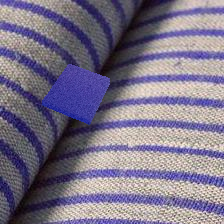

Label: 1
Prediction: 1 (1.0)

------------------------------


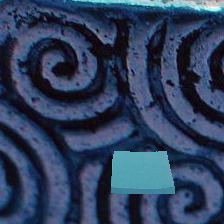

Label: 1
Prediction: 1 (1.0)

------------------------------


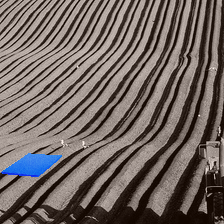

Label: 1
Prediction: 0 (3.453240209007016e-19)

------------------------------


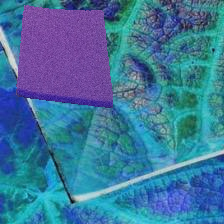

Label: 1
Prediction: 1 (1.0)

------------------------------


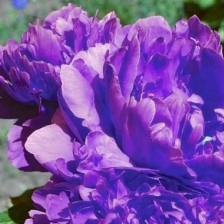

Label: 0
Prediction: 0 (0.0)

------------------------------


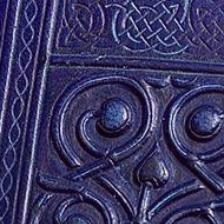

Label: 0
Prediction: 0 (0.0)

------------------------------


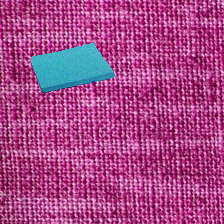

Label: 1
Prediction: 1 (1.0)

------------------------------


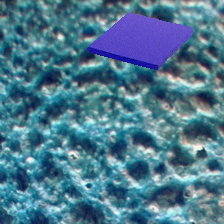

Label: 1
Prediction: 1 (1.0)

------------------------------


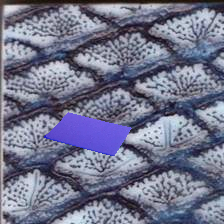

Label: 1
Prediction: 1 (1.0)

------------------------------


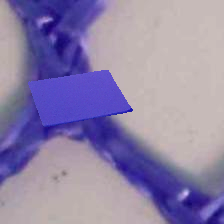

Label: 1
Prediction: 1 (1.0)

------------------------------


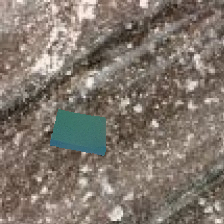

Label: 1
Prediction: 1 (1.0)

------------------------------


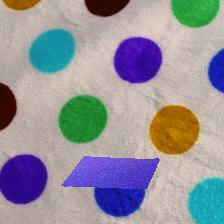

Label: 1
Prediction: 1 (1.0)

------------------------------


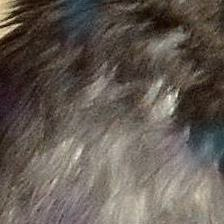

Label: 0
Prediction: 0 (5.181321205958468e-14)

------------------------------


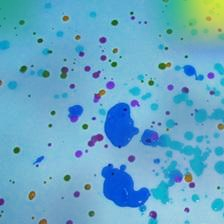

Label: 0
Prediction: 0 (1.7074115558901592e-12)

------------------------------


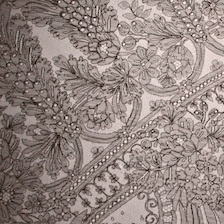

Label: 0
Prediction: 0 (4.6924169790390605e-23)

------------------------------


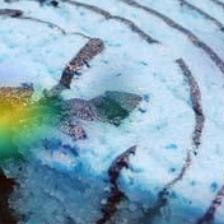

Label: 0
Prediction: 0 (4.14350047606149e-08)

------------------------------


KeyboardInterrupt: 

In [76]:
import eli5
import numpy as np

# # remove softmax
# l = model.get_layer(index=-1) # get the last (output) layer
# l.activation = linear # swap activation

# # save and load back the model as a trick to reload the graph
# model.save('tmp_model_save_rmsoftmax') # note that this creates a file of the model
# model = keras.models.load_model('tmp_model_save_rmsoftmax')

for f in image_files:
    image_path = os.path.join(png_path, image_set, f)
    image = Image.open(image_path)
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    label = f.split('-')[1].replace('.png', '')
    label = label == 'True'
    
    prediction = model.predict(image)[0][0]
    display(eli5.show_prediction(model, image))
    print(f'Label: {label * 1}')
    print(f'Prediction: {int(round(prediction))} ({prediction})')
    print('\n' + '-' * 30)

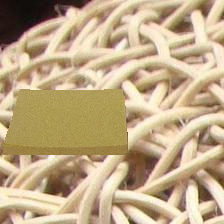

stickie


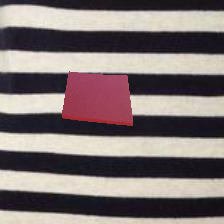

stickie


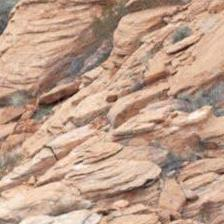

not stickie


In [56]:
from PIL import Image
import numpy as np

test_set, _ = read_dataset('../data/processed/tfrecords/1000-examples/test.tfrecord')

for item in test_set.take(3):
    img = item[0]
    np_img = img.numpy()
    display(Image.fromarray(np_img[0]))
    if model.predict(img)[0][0] == 1:
        print('stickie')
    else:
        print('not stickie')

### Random online image

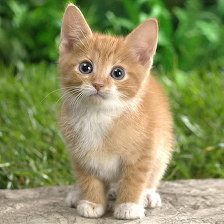

not stickie


In [54]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

# Load
url = 'https://pytorch.org/tutorials/_images/cat_superres_with_ort.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
# Display
np_img = np.array(img)
np_img = cv2.resize(np_img, (224, 224))
display(Image.fromarray(np_img))
# Preprocess
np_img = np_img.reshape(1, *np_img.shape)
tf_img = preprocess_input(np_img)
# Predict
if model.predict(tf_img)[0][0] == 1:
    print('stickie')
else:
    print('not stickie')

### Real world images

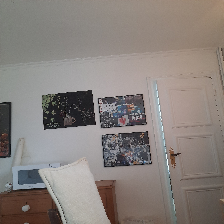

stickie


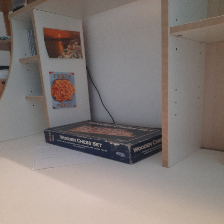

stickie


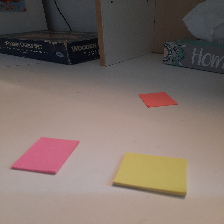

stickie


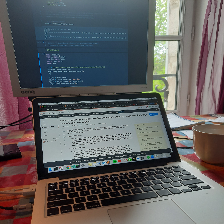

stickie


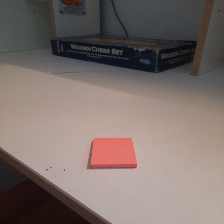

stickie


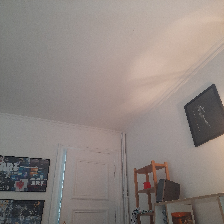

not stickie


In [55]:
test_dir = '../data/raw/test_images'
for image in os.listdir(test_dir):
    # Load and display
    img = Image.open(os.path.join(test_dir, image))
    np_img = np.array(img)
    np_img = cv2.rotate(np_img, 0)
    np_img = np_img[:3500]
    np_img = cv2.resize(np_img, (224, 224))
    display(Image.fromarray(np_img))
    # Preprocess
    np_img = np_img.reshape(1, *np_img.shape)
    tf_img = preprocess_input(np_img)
    # Predict
    if model.predict(tf_img)[0][0] == 1:
        print('stickie')
    else:
        print('not stickie')